In [1]:
import copy
import multiprocessing
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.stats import pearsonr, ttest_ind, f_oneway, chi2_contingency
from scipy.stats import randint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [2]:
dataset = pd.read_csv("test_scores.csv")

In [3]:
np.random.seed(0)

## Introduction

In this notebook, we are building a regression model based on the Kaggle dataset [here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students). Given students' pretest score and other features related to their school and education, the goal is to predict the posttest score. 

We first conducted some data exploration to better understand the dataset and find a subset of useful predictors. Then we proceeded to prepare the data so we could start build models. Given the conclusions from our data exploration step, three models were trained: a very simple linear regression model with a single input variable (to be used as a baseline), a multiple linear regression model and a random forest. For this last case we applied hyperparameter tuning by means of a randomised search and evaluated its potential overfitting. 

## Initial exploration

The first thing to notice is that the dataset contains few observations:

In [4]:
len(dataset)

2133

I am taking a look at the head and the tail of the dataset to get a quick idea of how the data looks like:

In [5]:
dataset.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20.0,2FHT3,Female,Does not qualify,62.0,72.0
1,ANKYI,Urban,Non-public,6OL,Standard,20.0,3JIVH,Female,Does not qualify,66.0,79.0
2,ANKYI,Urban,Non-public,6OL,Standard,20.0,3XOWE,Male,Does not qualify,64.0,76.0
3,ANKYI,Urban,Non-public,6OL,Standard,20.0,556O0,Female,Does not qualify,61.0,77.0
4,ANKYI,Urban,Non-public,6OL,Standard,20.0,74LOE,Male,Does not qualify,64.0,76.0


In [6]:
dataset.tail()

,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest
2128,ZOWMK,Urban,Public,ZBH,Standard,30.0,T8LSK,Female,Does not qualify,39.0,55.0
2129,ZOWMK,Urban,Public,ZBH,Standard,30.0,VNP26,Female,Qualifies for reduced/free lunch,38.0,46.0
2130,ZOWMK,Urban,Public,ZBH,Standard,30.0,YDR1Z,Female,Qualifies for reduced/free lunch,45.0,51.0
2131,ZOWMK,Urban,Public,ZBH,Standard,30.0,YUEIH,Male,Qualifies for reduced/free lunch,46.0,53.0
2132,ZOWMK,Urban,Public,ZBH,Standard,30.0,ZVCQ8,Male,Qualifies for reduced/free lunch,41.0,48.0


We didn't detect any missing values (or empty strings), so no missing data imputation is required:

In [7]:
dataset.isna().sum() + (dataset == "").sum()

school             0
school_setting     0
school_type        0
classroom          0
teaching_method    0
n_student          0
student_id         0
gender             0
lunch              0
pretest            0
posttest           0
dtype: int64

Next, we take a look at the type of the features in the dataset. The output variable is numerical, as well as a couple of input variables. The rest of input variables are categorical (we assume the object columns to be strings):

In [8]:
dataset.dtypes

school              object
school_setting      object
school_type         object
classroom           object
teaching_method     object
n_student          float64
student_id          object
gender              object
lunch               object
pretest            float64
posttest           float64
dtype: object

Therefore, we apply type casting to make it explicit that this `object` features are categorical:

In [9]:
cat = dataset.dtypes[dataset.dtypes == object].index.values.tolist()
dataset[cat] = dataset[cat].astype(dtype="category")

This function will help us to programmatically extract a list with the name of the categorical and numerical columns, based on their types.

In [10]:
def column_types(df):
    cat = df.dtypes[df.dtypes == "category"].index.values.tolist()
    num = df.drop(cat, axis=1).columns.tolist()
    
    return (cat, num)

In [11]:
cat, num = column_types(dataset)

In [12]:
cat

['school',
 'school_setting',
 'school_type',
 'classroom',
 'teaching_method',
 'student_id',
 'gender',
 'lunch']

In [13]:
num

['n_student', 'pretest', 'posttest']

Let's take a look at the cardinality of the categorical features:

In [14]:
dataset[cat].nunique()

school               23
school_setting        3
school_type           2
classroom            97
teaching_method       2
student_id         2133
gender                2
lunch                 2
dtype: int64

The `student_id` column seems to be a unique identifier for each student, since it has as many values as observations in the dataset. Therefore, for the purpose of building regression models, we can get rid of:

In [15]:
dataset.drop(["student_id"], axis=1, inplace=True)

In [16]:
cat, num = column_types(dataset)

Once we remove the unique identifier, it is interesting to notice that there are actually only 298 different combinations of values for the categorical variables. This may be good news since it may be useful to give us an indication of the amount of noise in the predicted variable during the modelling stage:

In [17]:
len(dataset[cat].drop_duplicates())

298

## Data visualisation and feature selection

All the numerical features look closely normal, with no clear outliers.

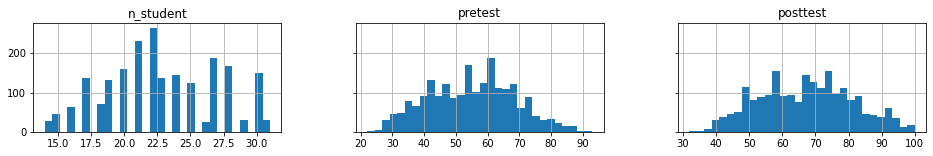

In [18]:
_ = dataset[num].hist(sharey=True, layout=(1,3), figsize=(16, 2), bins=30)

We take now a look at the correlation between each of the numerical input variables and `posttest`. As we can see below, the `pretest` score seems to be a very clear indication of what the `posttest` score is going to be. There is some homoscedastic variance. I wonder to which extent will the categorical features help explaining this variability.

The `n_student` feature doesn't seem to present a strong correlation with respect to `posttest`.

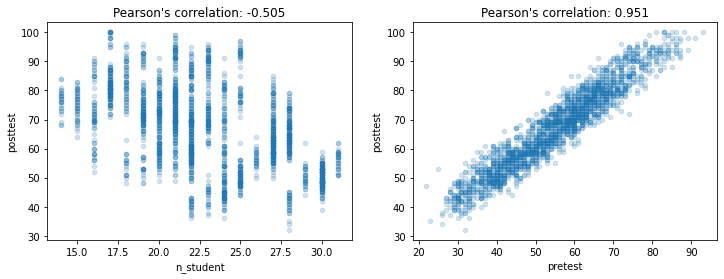

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i in range(2):
    cor = pearsonr(dataset[num[i]], dataset["posttest"])[0]
    dataset.plot.scatter(num[i], "posttest", alpha=0.2, ax=ax[i], title="Pearson's correlation: {:.3f}".format(cor))

Using side by side boxplots for each categorical feature we can get some idea of the correlation between categorical features and the numerical output variable. For each categorical variable, each box represents the distribution of `posttest` values for each of the categorical variable value:

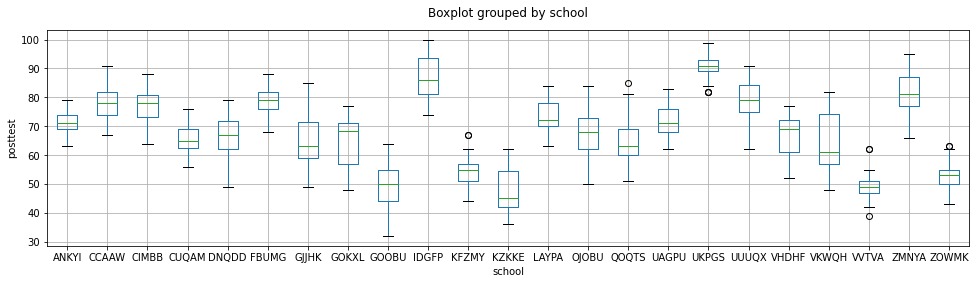

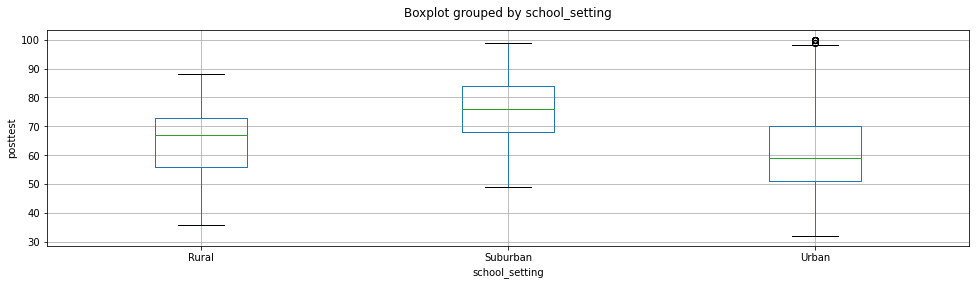

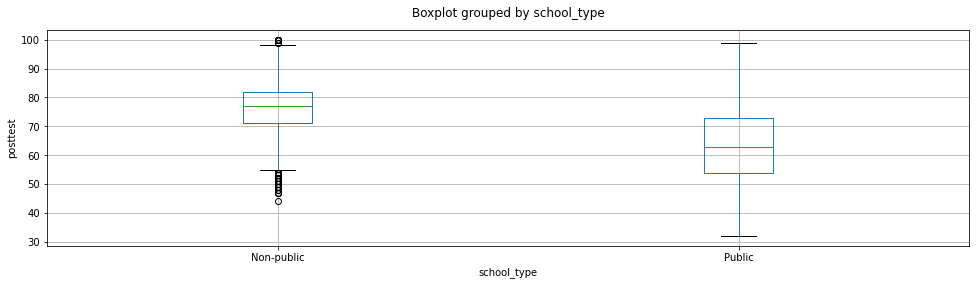

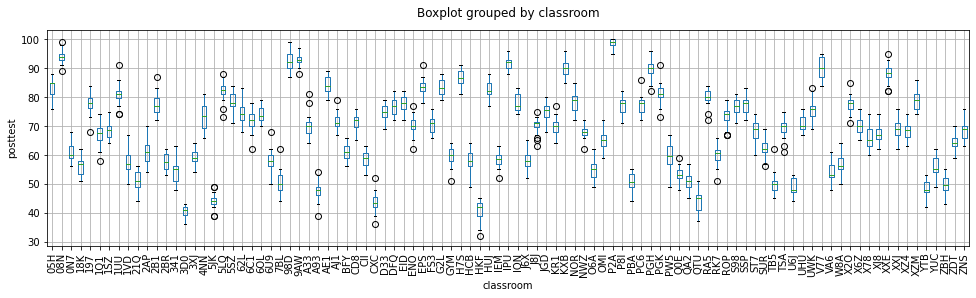

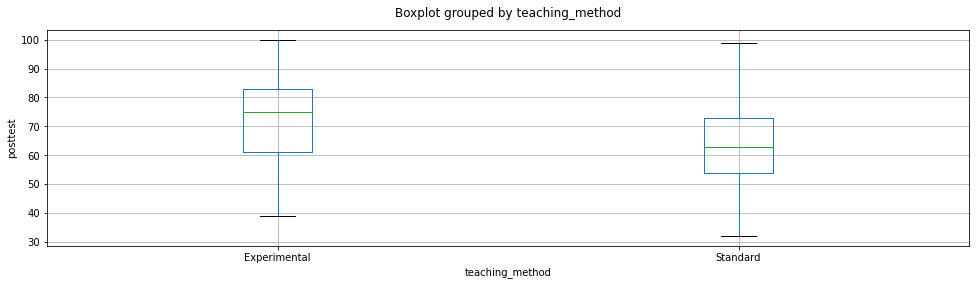

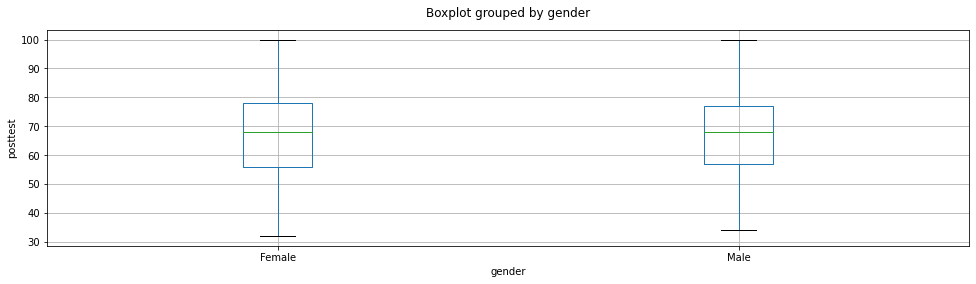

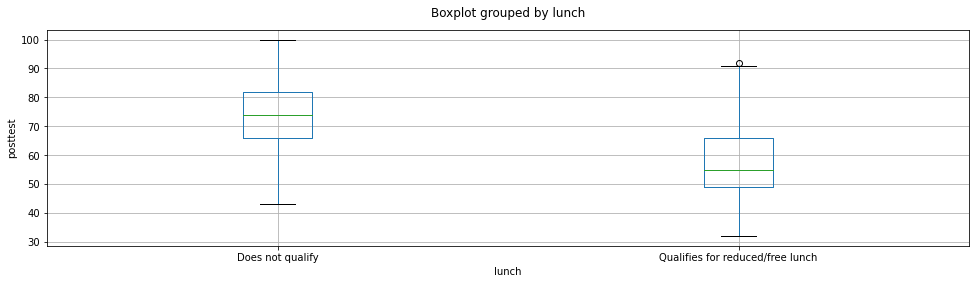

In [20]:
for c in cat:
    ax = dataset.boxplot("posttest", by=c, figsize=(16, 4))
    ax.set_ylabel("posttest")
    if c == "classroom":
        plt.xticks(rotation=90)
    _ = ax.set_title("")

By visual inspection it may seem that the `gender` feature does not have much impact in terms of predicting the `posttest` score. Let's do a more formal test. We apply two-sample t test hypothesis testing for each categorical variable having only two unique values, and an ANOVA test for the rest. The objective is to determine whether there is a difference in `posttest` scores for at least two of the categorical feature values:

In [21]:
def get_group_posttest(column, value):
    '''
    Extract the posttest data for all the observations in the dataset having a given value
    assigned in the indicated column
    '''
    return dataset[dataset[column] == value]["posttest"].values.tolist()

for c in cat:
    if dataset[c].nunique() == 2:
        val = dataset[c].unique()
        test = ttest_ind(get_group_posttest(c, val[0]), get_group_posttest(c, val[1]))
        print("Test results for {}: {}".format(c, test))

Test results for school_type: Ttest_indResult(statistic=18.61101342570606, pvalue=9.375658077322588e-72)
Test results for teaching_method: Ttest_indResult(statistic=-15.207130452439435, pvalue=1.1640893397303954e-49)
Test results for gender: Ttest_indResult(statistic=-0.3186213007906837, pvalue=0.7500449231810916)
Test results for lunch: Ttest_indResult(statistic=34.475520932132916, pvalue=2.2616015547526212e-207)


In [22]:
for c in cat:
    if dataset[c].nunique() > 2:
        val = dataset[c].unique()
        samples = [dataset[dataset[c] == v]["posttest"] for v in val]
        test = f_oneway(*samples)
        print("Test results for {}: {}".format(c, test))

Test results for school: F_onewayResult(statistic=367.3402670965681, pvalue=0.0)
Test results for school_setting: F_onewayResult(statistic=284.64490998276796, pvalue=2.7767850260221484e-110)
Test results for classroom: F_onewayResult(statistic=397.2819173475613, pvalue=0.0)


Looking at the test results, we see a p-value of 0.75 for the `gender` feature. This is the only feature for which we cannot reject the null hypothesis, and therefore we conclude that **we can safely get rid of the gender feature from the dataset**.

Another aspect of the data we noticed during visual inspection is that there seems to be a 1-1 relationship between `n_student` and `classroom`, i.e. all observations having the same `classroom` value will also have the same `n_student` value: 

In [23]:
(dataset[["classroom", "n_student"]].groupby("classroom").nunique() > 1).sum()

n_student    0
dtype: int64

It seems that `n_student` is just the number of observations in the dataset having the same `classroom` value. 

In [24]:
df1 = dataset[["classroom", "posttest"]].groupby("classroom").size() 
df2 = dataset[["classroom", "n_student"]].groupby("classroom").mean()
df = pd.concat([df1, df2], axis=1)
df.columns = ["size", "n_student"]
(df["size"] == df["n_student"]).all()

True

Therefore, **I'd suggest to we get rid of `n_student`**. The `classroom` feature has a higer cardinality that may provide more fine detail about the variability of the `posttest`.

Now we use chi-square hypothesis tests to evaluate the dependency between each pair of categorical features:

In [25]:
for comb in combinations(cat, 2):
    print(comb)
    print(chi2_contingency(pd.crosstab(dataset[comb[0]], dataset[comb[1]]))[1])

('school', 'school_setting')
0.0
('school', 'school_type')
0.0
('school', 'classroom')
0.0
('school', 'teaching_method')
7.228621507075362e-78
('school', 'gender')
0.0321155639821607
('school', 'lunch')
5.278576793788724e-281
('school_setting', 'school_type')
0.00020523800701307613
('school_setting', 'classroom')
0.0
('school_setting', 'teaching_method')
7.01305084172253e-05
('school_setting', 'gender')
0.06783227640136613
('school_setting', 'lunch')
5.016920354425382e-08
('school_type', 'classroom')
0.0
('school_type', 'teaching_method')
1.895447485787072e-12
('school_type', 'gender')
0.4454307653065481
('school_type', 'lunch')
3.945621936758178e-15
('classroom', 'teaching_method')
0.0
('classroom', 'gender')
0.11909947380042832
('classroom', 'lunch')
4.615977777621936e-232
('teaching_method', 'gender')
0.3775222025423609
('teaching_method', 'lunch')
0.43289028304865307
('gender', 'lunch')
0.4830627330388866


Most of the pairs of categorical variables seem to be quite dependent, with a 1-1 relationship existing between some of them (e.g. `school` and `school_setting`). There are some exceptions, involving mainly `gender` and `lunch`. We should take this into account during modelling - we need regularisation. 

Finally, we discard the two suggested input variables:

In [26]:
dataset.drop(["gender", "n_student"], axis=1, inplace=True)

In [27]:
cat, num = column_types(dataset)

In [28]:
len(dataset[cat].drop_duplicates())

161

Discarding theset two input variables decreased the number of combinations of unique values of categorical variables. 

## Data preprocessing and modelling

The first step is to apply one-hot encoding so that we can use the categorical features in our models. Two of the models we train below actually don't require this step (linear regression with a single numerical input variable and random forests) but we apply it anyway to be able to compare to multiple linear regression. 

In [29]:
dataset.shape

(2133, 8)

In [30]:
# Using k-1 dummy variables (dropfirst) to prevent correlation issues
X = pd.concat([pd.get_dummies(dataset[cat], drop_first=True), dataset[num]], axis=1)

In [31]:
X.shape

(2133, 125)

As a consequence of this we increase the number of features from 8 to 125. This dataset still fits in memory.

Next, we split the dataset into input and output variables:

In [32]:
y = dataset["posttest"]
X = X.drop("posttest", axis=1)

Now we split the dataset into a training set and a test set. The training set will be used to train models and hyperparameter tuning. The test set will be used to compare different models and will never be used to take decisions about how to train a specific model. We use a 40% of the dataset as a test set. That is a relatively high value, but we have a high proportion of duplicate combinations of categorical values. 

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

As in the case of one-hot encoding, we are applying data standardisation only because one of the models we will be training below (multiple linear regression) requires it:

In [34]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns)

## Model: linear regression (`pretest` vs. `posttest`)

As we noticed earlier, there is a very strong correlation between the pretest score and the posttest score. We will train a linear regression model that we will use as a baseline to compare with the rest of the models in this notebook. This way, we will be able to understand whether the categorical input variables are actually helping to explain the variability of the `posttest` scores. 

We are using mean squared error to evaluate this and the rest of the models in this notebook. 

In [35]:
# Train error
pretest = X_train["pretest"].values.reshape(-1, 1)
lin_reg = LinearRegression().fit(pretest, y_train)
y_pred = lin_reg.predict(pretest)
mean_squared_error(y_pred, y_train)

18.608284285164892

In [36]:
# Test error
pretest = X_test["pretest"].values.reshape(-1, 1)
y_pred = lin_reg.predict(pretest)
mean_squared_error(y_pred, y_test)

18.963575264769727

There's not much difference between train and test errors. That's an indication of lack of overfitting. However, the error is quite high when compared to that of the models below. That means that using only `pretest` is not enough to explain the `posttest` feature. 

## Model: multiple linear regression

We build now a multiple linear regression model using all the selected input variables. We are making an assumption that there is a linear relationship between the input variables and the output variable. This is totally the case of the `pretest` variable. The categorical variables have no ordering, but our exploration demonstrated some dependency between each of the categorical input variables and the output variable. 

In [37]:
# Train error
lin_reg = LinearRegression().fit(X_train, y_train)
y_pred = lin_reg.predict(X_train)
mean_squared_error(y_pred, y_train)

7.993588155765152

In [38]:
# Test error
y_pred = lin_reg.predict(X_test)
mean_squared_error(y_pred, y_test)

9.399959117759378

By using all the selected input features we obtain a much lower regression error. However, the difference between train error and test error is higher. Therefore, there's a bit more of overfitting. 

## Model: random forests

A random forest model seems like a sensible choice given the fact that we have both numerical and categorical variables. We are hopping that using bootstrapping and a fixed tree depth will respectively help to decrease the bias and overfitting.

Our first test was not that successful. Random forests in scikit-learn do not limit the depth of the tree, so we produce a model with much overfitting:

In [39]:
# Train error
rf = RandomForestRegressor().fit(X_train, y_train)
y_pred = rf.predict(X_train)
mean_squared_error(y_pred, y_train)

3.3877264916680216

In [40]:
# Test error
y_pred = rf.predict(X_test)
mean_squared_error(y_pred, y_test)

11.11499082630678

The test error is larger than that of a much simpler model (multiple linear regression).

Let's try hyperparemter tuning by means of randomized search (so this process doesn't take that much time to run). For that we will apply 10-fold cross validation to the training dataset. I am testing the parameters that in my experience usually have a bigger impact. I chose only two parameters to prevent the curse of dimensionality. 

In [41]:
jobs = multiprocessing.cpu_count() - 1
rf = RandomForestRegressor()
distributions = dict(n_estimators=randint(10, 1000), max_depth=randint(5, 100))
search = RandomizedSearchCV(rf, distributions, n_jobs=jobs, n_iter=jobs * 10, cv=10).fit(X_train, y_train)

The best results are obtained for the following hyperparameter values:

In [42]:
search.best_params_

{'max_depth': 7, 'n_estimators': 164}

In [43]:
# Train error
rf = RandomForestRegressor(**search.best_params_).fit(X_train, y_train)
y_pred_t = rf.predict(X_train)
mean_squared_error(y_pred_t, y_train)

6.345661013413479

In [44]:
# Test error
y_pred = rf.predict(X_test)
mean_squared_error(y_pred, y_test)

10.346633382390435

Unfortunately, even though we managed to decrease overfitting, the test error is still higher than that of the multiple linear regression model.

However, we can still use these results to try to measure the importance of each of the input variables. The plot below shows the importance score (notice the logarithmic scale) of the 10 most important features:

Text(0.5, 0, 'importance (log)')

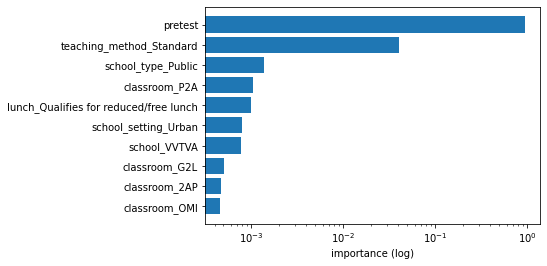

In [45]:
# Feature importance - showung only the 10 most important ones
s = np.argsort(rf.feature_importances_)
fig, ax = plt.subplots()
ax.barh(X_train.columns[s][-10:], rf.feature_importances_[s][-10:])
ax.set_xscale("log")
ax.set_xlabel("importance (log)")

It seems that most of the variability in the output variable is explained obviously by `pretest` but also by the teaching method and the type of school. These two last features are extrinsic to the student, and highlight the importance of applying correct teaching metrics and the impact of studing or not in a public school. 

This importance may be use by educators and councils to take decisions about how to improve grades in schools. 

Unfortunately, using only these three most important features does not produce better results:

In [46]:
# Train error
X_train_s = X_train[X_train.columns[s][-3:]]
rf = RandomForestRegressor(**search.best_params_).fit(X_train_s, y_train)
y_pred = rf.predict(X_train_s)
mean_squared_error(y_pred, y_train)

8.228708298252077

In [47]:
# Test error
X_test_s = X_test[X_test.columns[s][-3:]]
y_pred = rf.predict(X_test_s)
mean_squared_error(y_pred, y_test)

11.712184177844636

Coming back to the random forest we trained after hyperparameter tuning using all the selected input variables, let's take a look at the distribution of the residuals: 

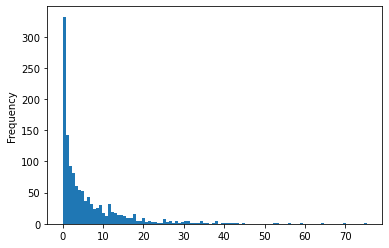

In [48]:
res = np.power(y_pred_t - y_train, 2)
_ = res.plot.hist(bins=100)

We could start a systematic error analysis process in which we analyse the features of the outliers on the right hand side of the plot, that is, the least accurate predictions. This systematic error analysis could help us focus on those observations that are harder to predict correctly. 

In [49]:
indices = np.argwhere(res.values > 50).flatten().tolist()

In [50]:
indices

[14, 147, 187, 556, 577, 914, 1093]

In [51]:
# Taken from https://stackoverflow.com/questions/50607740/reverse-a-get-dummies-encoding-in-pandas
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df


In [52]:
X_train.index = range(len(X_train))
y_train.index = range(len(y_train))
pd.concat((undummify(X_train).iloc[indices, :], y_train.iloc[indices]), axis = 1)

,school,classroom,teaching,lunch,pretest,posttest
14,OJOBU,6U9,method_Standard,Qualifies for reduced/free lunch,-0.434681,68.0
147,ZMNYA,1UU,method_Standard,Qualifies for reduced/free lunch,0.814165,91.0
187,CUQAM,1Q1,method_Standard,Qualifies for reduced/free lunch,0.079550,74.0
556,ZOWMK,QA2,method_Standard,Qualifies for reduced/free lunch,-0.875450,45.0
577,DNQDD,ST7,method_Standard,Qualifies for reduced/free lunch,0.373396,61.0
914,DNQDD,2AP,method_Standard,Qualifies for reduced/free lunch,0.006088,55.0
1093,VKWQH,GYM,method_Standard,Qualifies for reduced/free lunch,-0.508142,51.0


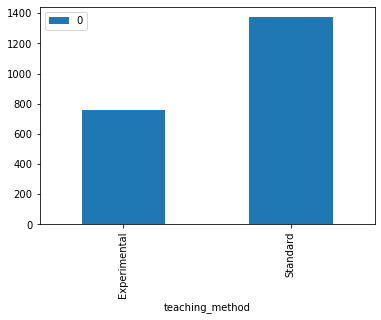

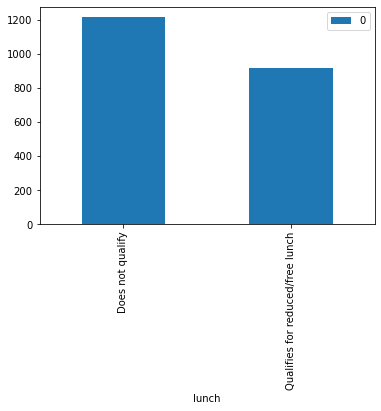

In [53]:
for c in ["teaching_method", "lunch"]:
    dataset[["teaching_method", "lunch"]].groupby(c).size().reset_index().plot.bar(c)

All these observations had the same values for the `lunch` and `teaching_method` variables. There seems to be some imbalance in the proportion of values for these variables in the dataset. Given the importance of `teaching_method` in the prediction, we could in the future use stratification when sampling the training and test sets to make sure that we have a proportional representation.

## Evaluation: learning curve

In this last step we plot the learning curve for the random forest based on the complete set of chosen features. This is done by plotting the running average of the cross-validated training and test errors as we increase the size of the input dataset.

In [54]:
# Learning curve
X_train, y_train = shuffle(X_train, y_train)

In [55]:
rf = RandomForestRegressor(**search.best_params_, random_state = 0)
training = []
test = []
for i in tqdm(np.arange(10, len(X_train), 10)):
    X_i = X_train.values[:i, :]
    y_i = y_train[:i]
    scores = cross_validate(rf, X_i, y_i, cv=10, return_train_score=True, scoring = "neg_mean_absolute_error")
    training.append(scores["train_score"])
    test.append(scores["test_score"])

100%|██████████| 127/127 [07:23<00:00,  3.49s/it]


Text(0.5, 1.0, 'learning curve')

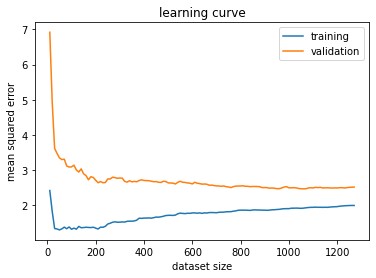

In [56]:
fig, ax = plt.subplots()
ax.plot(np.arange(10, len(X_train), 10), -np.array(training).mean(axis=1))
ax.plot(np.arange(10, len(X_train), 10), -np.array(test).mean(axis=1))
ax.legend(["training", "validation"])
ax.set_xlabel("dataset size")
ax.set_ylabel("mean squared error")
ax.set_title("learning curve")

We can see how the two lines are converging on the right hand side. This means that increasing the size of our dataset is not necessarily going to have an impact on regression accuracy. The fact that we reached convergence also indicates that the distance between training and validation errors (overfitting) is the natural overfit we can expect from our model given the total population from which we extracted our sample.

## Conclusions

For this particular dataset, a simpler model (multiple linear regression) seemed to perform better than a more complex model (random forests). However, our hyperparameter tuning was not exhaustive and results could have been improved by applying gridsearch or considering other hyperparemeters as part of the search space.

The pre-test score is a very good indicator of what the post-test score is going to be, but it is not the only factor. Other parameters, like the type of school or whether the student qualifies for free lunch are also important and should be considered.